# Introduction to Quantitative Finance

Copyright (c) 2019 Python Charmers Pty Ltd, Australia, <https://pythoncharmers.com>. All rights reserved.

<img src="img/python_charmers_logo.png" width="300" alt="Python Charmers Logo">

    Published under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. See `LICENSE.md` for details.

Sponsored by Tibra Global Services, <https://tibra.com>

<img src="img/tibra_logo.png" width="300" alt="Tibra Logo">


## Module 1.4: Principle Component Analysis (PCA)

### 1.4.2 PCA Interpretation

In the last notebook we introduced the Principle Component Analysis algorithm - PCA. In this notebook we will look at the algorithm in more detail, including methods for analysing the results.

From a linear algebra perspective, the algorithm itself is quite straightforward:

1. Normalise X to have a zero mean (`X = X - np.mean(X, axis=0)`)
2. Calculate the covariance matrix $\Sigma$, which is a square matrix of size `k`, the number of variables, where value $\Sigma_{i,j}$ is the covariance of variables $i$ and $j$. Note that $\Sigma = X'X$.
3. Find the eigenvectors of $\Sigma$

The resulting eigenvectors will be the component and the eigenvalues of those will be the relative variance explained by the given component. If you sort the eigenvectors by their eigenvalues (highest first), you get the sorted eigenvectors, giving the sorted (by importance) principle components.

To compute the transformed data, perform a dot product $XC$, where $C$ is a matrix of the first $n$ components we are interested in (which could be "all of them" if $n=k$).

In [1]:
%run setup.ipy


#### Exercise

1. Review the documentation for the scikit-learn PCA algorithm, as well as the linked description. What does the `whiten` parameter do and when is it useful?


#### Extended Exercise

Implement the PCA algorithm as given above using only the NumPy algorithm.

**Hint:** The `np.linalg.eig` function can be used for computing the eigenvectors and eigenvalues, although they won't be sorted correctly.




In [2]:
from dataclasses import dataclass

In [63]:
@dataclass
class PCAH:
    components_: np.ndarray
    explained_variance_ : np.ndarray

In [71]:
def homespun_pca(X: np.ndarray, number_components=2):
    X_normed = X - np.mean(X, axis=0)
    Cov = np.cov(X_normed.T)
    eigen_values, eigen_vectors = np.linalg.eig(Cov)
    
    # Sort from largest eigenvalue to smallest
    index = eigen_values.argsort()[::-1]

    eigen_vectors = eigen_vectors[:,index]
    eigen_values = eigen_values[index]

    return PCAH(eigen_vectors[:,:number_components], eigen_values[:number_components])
    

In [14]:
# Generate test data
np.random.seed(1)
NDIMS = 2
X = np.dot(np.random.random(size=(NDIMS, NDIMS)), np.random.normal(size=(NDIMS, 200))).T

In [68]:
X_normed = X - np.mean(X, axis=0)
Cov_2 = np.cov(X_normed.T)
Cov = X_normed.T @ X_normed / X.shape[0]

print(Cov_2)
print(Cov)

[[0.68217761 0.23093475]
 [0.23093475 0.09883179]]
[[0.67876672 0.22978007]
 [0.22978007 0.09833763]]


In [54]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
print("SKLearn Eigenvectors and values:")
print(pca.components_)
print(pca.explained_variance_)

SKLearn Eigenvectors and values:
[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
[0.7625315 0.0184779]


In [70]:
print("Homespun Eigenvectors and values:")
pcah = homespun_pca(X, number_components=2)
print(pcah.components_)
print(pcah.explained_variance_)

Homespun Eigenvectors and values:
[[ 0.94446029 -0.32862557]
 [ 0.32862557  0.94446029]]
[0.7625315 0.0184779]


*For solutions, see `solutions/pca_numpy.py`*

### Eigenvectors and Eigenvalues

Eigenvectors are an area of linear algebra that often causes lots of confusion. You *can* simply use PCA without knowing what they are. They are used within the algorithm, but the values that you normally use are the transformed dataset $X$, rather than the eigenvectors and eigenvalues themselves.

However, an intuitive understanding of Eigenvectors can often help. To help with this, the following video on YouTube has the incredibly clear explanation and useful visualisations:

<iframe width="560" height="315" src="https://www.youtube.com/embed/PFDu9oVAE-g" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>

(If that doesn't load, which can happen due to security settings, click this link: https://www.youtube.com/watch?v=PFDu9oVAE-g )

Usefully, the above video also talks about the change in basis, which is what PCA is effectively doing to your data.

Details about linear algebra are outside the scope of this course, but I would recommend the full series of videos in the above playlist to fill any gaps in understanding. Also, the visualisations are written in Python!

### Limitations of PCA

PCA is not a perfect algorithm (such a thing doesn't exist), and using it has drawbacks. These are listed below:

### Computation Requirements

From a practical perspective, it can be very computationally heavy to undertake PCA on a dataset, particularly a large one. For this reason, methods like a [Randomised PCA](http://lijiancheng0614.github.io/scikit-learn/modules/generated/sklearn.decomposition.RandomizedPCA.html) which gives an approximation that is normally good enough practically, but takes far less computation time.


### Sparse Representations

Another limitation of PCA is that the resulting vectors from a PCA transformation are often quite dense. What this means, is that many of the values in the components are non-zero. From a mathematical perspective, this doesn't matter. However, from a computational perspective, having lots of zero elements in a vector allows us to use sparse representations and sparse computation. Sparse representations reduce the amount of space it takes to save data. As an example, consider the vector:

    x = np.array([0, 0, 3, 9, 0, 0, 0, 0, 0, 0])
    
This vector has 10 values, of which 8 are zero. Storing the vector as above, with zeros, in memory, takes 10 chunks of memory (where a chunk is based on the data type, so likely it would be 32 bits). In contrast, we can *assume* values are zero, and just store the non-zero values, and where they sit on this vector. In pseudo code:

    x is a vector with 10 spots, defaulting to zero
    there is a 3 at index 2
    there is a 9 at index 3
    
This means we can store this whole vector as something like (again, not real code):

    x = sparse_vector([(3, 2), (9, 3)])
    
Just four numbers, resulting in a saving of 60% of the total memory. This idea also generalises well to higher dimensions (you just record the full co-ordinates). As you might suspect, the actual implementation will be more than 4 numbers, but the general pattern is roughly consistent with this analysis. In short, you should use sparse matrices if you expect more than 60% of the data to be zeros.

Additionally, if you know that you are using sparse vectors and matrices, you can use specialised algorithms (both mathematical and computational) that take advantage of this fact. This type of algorithm takes *longer* for dense matrices, but *less time* for sparse matrices. For an example, see the [Sparse PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparsePCA.html)


#### Exercises

1. Run a SparsePCA, RandomizedPCA and (normal) PCA analysis on some data, and compare the explained variance ratio graphs for each.
2. Rerun the same analysis on a *very large* dataset, while profiling the result. You can time how long code takes in a Jupyter notebook using the `%time` command:

In [12]:
# Generate test data
np.random.seed(1)
NDIMS = 50
X = np.dot(np.random.random(size=(NDIMS, NDIMS)), np.random.normal(size=(NDIMS, 1000))).T

CPU times: user 69.9 ms, sys: 79.1 ms, total: 149 ms
Wall time: 11 ms
CPU times: user 1min 7s, sys: 2min 16s, total: 3min 24s
Wall time: 13.3 s
CPU times: user 720 ms, sys: 301 ms, total: 1.02 s
Wall time: 63.8 ms


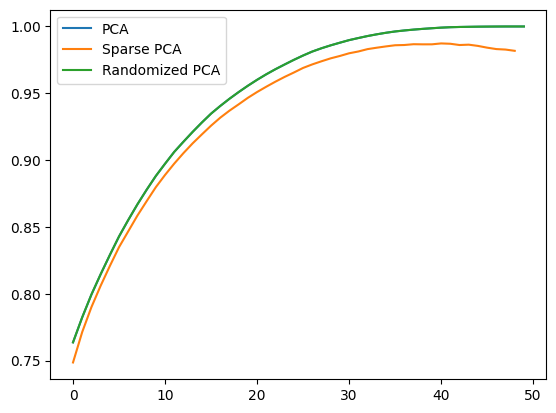

In [19]:
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

pca = PCA(n_components=NDIMS)
%time pca.fit(X)

sparce_pca = SparsePCA(n_components=NDIMS)
%time sparce_pca.fit(X)
# Explained Variance doesn't make full sense for sparse PCA https://github.com/scikit-learn/scikit-learn/issues/11512
sparce_pca_explained_variance = []

for n in range(1,NDIMS):
    sparce_pca = SparsePCA(n_components=n)
    sparce_pca.fit(X)
    P = sparce_pca.components_.T  # loadings
    T = sparce_pca.transform(X)  # score
    Xc = X - X.mean(axis=0)  # center data

    explained_variance = np.trace(P @ T.T @ T @ P.T)
    total_variance = np.trace(Xc.T @ Xc)
    sparce_pca_explained_variance.append(explained_variance / total_variance)

sparce_pca_explained_variance = np.array(sparce_pca_explained_variance)

randomized_pca = PCA(n_components=NDIMS, svd_solver='randomized')
%time randomized_pca.fit(X)

fig, ax = plt.subplots()
ax.plot(np.cumsum(pca.explained_variance_ratio_), label="PCA")
ax.plot(sparce_pca_explained_variance, label="Sparse PCA")
ax.plot(np.cumsum(randomized_pca.explained_variance_ratio_), label="Randomized PCA")
ax.legend()


In [4]:
import time

def my_function():
    # A function that takes a while to compute. On my computer, about 11 seconds
    time.sleep(1)
    j = 0
    for i in range(int(10e7)):
        j += i

In [5]:
%time my_function()

Wall time: 5.54 s


### Orthogonal representations

A mathematical limit of PCA is that it relies on orthogonal transformations of the data. That means that every component will be orthogonal to each other.

This is a good "rule of thumb" that works well for many datasets, but there are lots of datasets for which this type of transformation doesn't really help. For instance, consider this dataset, created from two different underlying models:

In [2]:
x_part_1 = np.arange(100) * 3 + 4 + np.random.random(100) * 50
x_part_2 = np.arange(100) * 1.1 - 2 + np.random.random(100) * 60

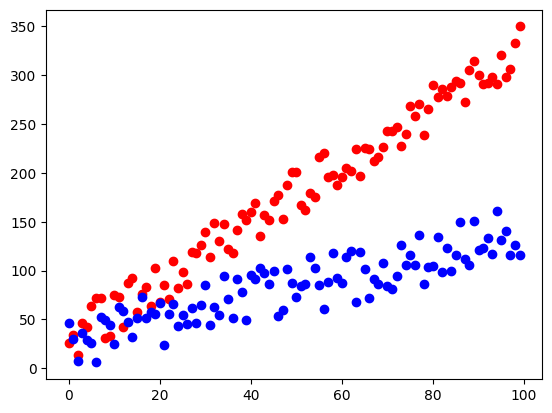

In [3]:
plt.plot(x_part_1, 'ro')
plt.plot(x_part_2, 'bo')

In the above dataset, the best transformations would be the lines $3x + 4$ and $1.1x - 2$. However, PCA wouldn't find these lines. It would find the singular line-of-best-fit, and then the best line orthogonal to it:

In [4]:
y_data = np.hstack([x_part_1, x_part_2])
x_data = np.hstack([np.arange(100), np.arange(100)])
X = np.vstack([x_data, y_data]).T
X.shape

(200, 2)

In [5]:
from sklearn.decomposition import PCA
parts_PCA = PCA(n_components=2)
parts_PCA.fit(X)

PCA(n_components=2)

In [6]:
parts_PCA.components_

array([[ 0.2597897 ,  0.96566522],
       [ 0.96566522, -0.2597897 ]])

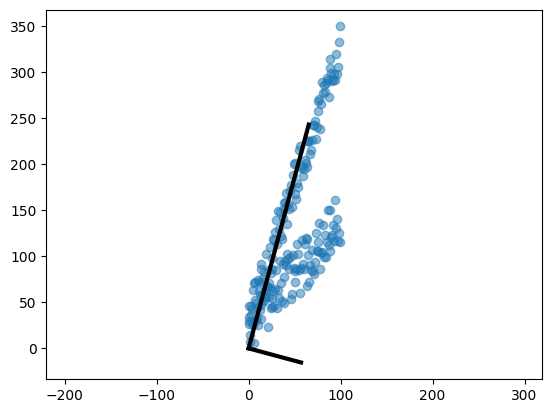

In [7]:
plt.plot(X[:, 0], X[:, 1], 'o', alpha=0.5)
for length, vector in zip(parts_PCA.explained_variance_, parts_PCA.components_):
    v = vector * 3 * np.sqrt(length)  # The "3" just scales so the graph looks good
    plt.plot([0, v[0]], [0, v[1]], '-k', lw=3)
plt.axis('equal');

Here, the line of best fit for the dots in blue above aren't represented well by this transformation. Instead, you can use other Factor analysis methods to find this type of transformation.

### Variance isn't everything

PCA also assumes that the mean and covariance matrices effectively describe the dataset. Many datasets do not following this fact. If your distribution isn't effectively describe with a combination of a mean and variance value, then PCA is not going to give you a useful representation of your data. As an example, a Gaussian distribution is *only* defined by its mean and variance. Many distributions have more parameters.

Despite this, even if a distribution can't be described with just a mean and variance, a PCA may still provide a useful result.

Further to the above, PCA also assumes that *explaining the variance explains the data*. This is a consequence also that PCA is **scale variant**, which causes numbers with higher values and variances to be considered more important than numbers with lower values, even if those lower values are actually more important in the data. A common fix for this is to compute $z-scores$ for each variable, and then compute the PCA on the resulting Z scores instead.


### A Linear Assumption

PCA also assumes that the best way of looking at your data is as a linear combination of each other. Many relationships have more complicated relationships (log transformations, polynomial, exponent), and PCA cannot account for this.

#### Extended Exercise

Download the Quandl dataset "Capital Market Yields – Government Bonds - Daily" from Quandl (code `RBA/F02`), compute the change in value per row (diff), and then perform the following steps:

1. Split the data into a training set and a testing set. The test set contains the last row of the data. The training set contains all the previous data.
2. *With only the training dataset*, fit a PCA model and extract the principle components
3. How many principle components are needed to fit at least 99% of the variance in the data?
4. Fit a OLS estimator on the lagged data, *for each principle component*. I explain this further below.
5. Project the data into the test period, by taking the bias and coefficients of the OLS and predicting the next values.
6. Map the projections onto the original data space, by taking the PCA's inverse, to get the actual predicted values
7. Calculate the sum of squared error for your predictions.



In step 4 above, I ask that we fit an OLS on each principle component. If we have a principle component $C$, we want to use the value $c_{n-1}$ to predict the value $c_{n}$ using the linear equation $c_n = \beta_0 + \beta_1 c_{n-1}$. In other words, we fit a linear model saying "given the a value of this variable in a time series, what is the next value?". This type of analysis, moving average, will be reviewed further in a future notebook (1.6.1). 

Solution is in `solutions/PCA Application Example Solution.ipynb`

In [20]:
import quandl
CMYGB = quandl.get("RBA/F02")

In [121]:
CMYGB.head()

,Australian Government 2 year bond. Units: Per cent per annum; Series ID: FCMYGBAG2D,Australian Government 3 year bond. Units: Per cent per annum; Series ID: FCMYGBAG3D,Australian Government 5 year bond. Units: Per cent per annum; Series ID: FCMYGBAG5D,Australian Government 10 year bond. Units: Per cent per annum; Series ID: FCMYGBAG10D,Australian Government Indexed Bond. Units: Per cent per annum; Series ID: FCMYGBAGID,NSW Treasury Corporation 3 year bond. Units: Per cent per annum; Series ID: FCMYGBNT3D,NSW Treasury Corporation 5 year bond. Units: Per cent per annum; Series ID: FCMYGBNT5D,NSW Treasury Corporation 10 year bond. Units: Per cent per annum; Series ID: FCMYGBNT10D
Date,,,,,,,,
2013-05-20,2.480,2.530,2.760,3.220,1.050,2.896768,3.249395,3.9525
2013-05-21,2.520,2.570,2.795,3.255,1.050,2.939367,3.288894,3.9860
2013-05-22,2.535,2.580,2.805,3.265,1.075,2.954646,3.303860,3.9993
2013-05-23,2.530,2.585,2.825,3.295,1.100,2.954962,3.310891,4.0256
2013-05-24,2.540,2.595,2.840,3.310,1.105,2.973280,3.334475,4.0450


In [289]:
CMYGB_change = CMYGB.diff(1).dropna()

In [290]:
CMYGB_change.head()

,Australian Government 2 year bond. Units: Per cent per annum; Series ID: FCMYGBAG2D,Australian Government 3 year bond. Units: Per cent per annum; Series ID: FCMYGBAG3D,Australian Government 5 year bond. Units: Per cent per annum; Series ID: FCMYGBAG5D,Australian Government 10 year bond. Units: Per cent per annum; Series ID: FCMYGBAG10D,Australian Government Indexed Bond. Units: Per cent per annum; Series ID: FCMYGBAGID,NSW Treasury Corporation 3 year bond. Units: Per cent per annum; Series ID: FCMYGBNT3D,NSW Treasury Corporation 5 year bond. Units: Per cent per annum; Series ID: FCMYGBNT5D,NSW Treasury Corporation 10 year bond. Units: Per cent per annum; Series ID: FCMYGBNT10D
Date,,,,,,,,
2013-05-21,0.040,0.040,0.035,0.035,0.000,0.042599,0.039499,0.0335
2013-05-22,0.015,0.010,0.010,0.010,0.025,0.015279,0.014966,0.0133
2013-05-23,-0.005,0.005,0.020,0.030,0.025,0.000315,0.007031,0.0263
2013-05-24,0.010,0.010,0.015,0.015,0.005,0.018318,0.023584,0.0194
2013-05-27,-0.030,-0.030,-0.035,-0.040,-0.025,-0.028172,-0.027639,-0.0272


In [291]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=2, test_size=1)

In [292]:
# Just use the final split which stores the final datapoint as test data.
train_index, test_index = list(tscv.split(CMYGB_change))[-1]
X_train = CMYGB_change.iloc[train_index]
X_test = CMYGB_change.iloc[test_index]

In [293]:
X_train.tail()

,Australian Government 2 year bond. Units: Per cent per annum; Series ID: FCMYGBAG2D,Australian Government 3 year bond. Units: Per cent per annum; Series ID: FCMYGBAG3D,Australian Government 5 year bond. Units: Per cent per annum; Series ID: FCMYGBAG5D,Australian Government 10 year bond. Units: Per cent per annum; Series ID: FCMYGBAG10D,Australian Government Indexed Bond. Units: Per cent per annum; Series ID: FCMYGBAGID,NSW Treasury Corporation 3 year bond. Units: Per cent per annum; Series ID: FCMYGBNT3D,NSW Treasury Corporation 5 year bond. Units: Per cent per annum; Series ID: FCMYGBNT5D,NSW Treasury Corporation 10 year bond. Units: Per cent per annum; Series ID: FCMYGBNT10D
Date,,,,,,,,
2021-07-22,0.000,0.010,0.030,0.030,0.010,0.020,0.020,0.040
2021-07-23,0.000,0.000,0.005,0.005,0.000,-0.005,0.025,0.020
2021-07-26,0.005,0.005,-0.005,-0.015,-0.015,-0.005,-0.010,-0.010
2021-07-27,-0.005,0.000,0.005,0.030,0.010,0.005,-0.005,0.030
2021-07-28,-0.010,-0.010,-0.030,-0.055,0.005,-0.020,-0.030,-0.065


In [294]:
X_test.head()

,Australian Government 2 year bond. Units: Per cent per annum; Series ID: FCMYGBAG2D,Australian Government 3 year bond. Units: Per cent per annum; Series ID: FCMYGBAG3D,Australian Government 5 year bond. Units: Per cent per annum; Series ID: FCMYGBAG5D,Australian Government 10 year bond. Units: Per cent per annum; Series ID: FCMYGBAG10D,Australian Government Indexed Bond. Units: Per cent per annum; Series ID: FCMYGBAGID,NSW Treasury Corporation 3 year bond. Units: Per cent per annum; Series ID: FCMYGBNT3D,NSW Treasury Corporation 5 year bond. Units: Per cent per annum; Series ID: FCMYGBNT5D,NSW Treasury Corporation 10 year bond. Units: Per cent per annum; Series ID: FCMYGBNT10D
Date,,,,,,,,
2021-07-29,-0.005,-0.005,-0.005,0.0,0.01,-0.015,-0.02,0.005


In [295]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

PCA()

In [296]:
pca.explained_variance_ratio_

array([0.86334705, 0.08549526, 0.03012957, 0.00884915, 0.00538987,
       0.00341937, 0.00210719, 0.00126253])

In [297]:
cum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

In [298]:
# Minimum number of components to fit at least 99% of variance of the data:
index = np.amin(np.where(cum_explained_variance_ratio > 0.99))
print(f"Minimum number of components to fit at least 99% of variance of the data is {index + 1}, which explains {cum_explained_variance_ratio[index]}% of the variance.")

Minimum number of components to fit at least 99% of variance of the data is 5, which explains 0.9932109076298279% of the variance.


In [299]:
pca = PCA(n_components=0.99)
pca.fit(X_train)


PCA(n_components=0.99)

In [300]:
X_transformed_train = pca.transform(X_train)

In [301]:
import statsmodels.api as sm

projected_ols = []

# Using the previous day (aka row) to predict the next day (aka row). So for X_transformed_train[i] we want to predict X_transformed_train[i+1]
for training_data in X_transformed_train.T:
    X_tmp = training_data[:-1]
    Y_tmp = training_data[1:]

    X_tmp = sm.add_constant(X_tmp)

    ols = sm.OLS(Y_tmp, X_tmp).fit()
    projected_ols.append(ols)

In [302]:
# Predict value for the transformed test data
y_predict = []

for data, ols in zip(X_transformed_train.T[-1], projected_ols):
    data = np.array([data])
    data = sm.add_constant(data, has_constant='add')
    y_predict.append(ols.predict(data)[0])

In [303]:
print(f"Predicted projected values {y_predict}")

test_transformed = pca.transform(X_test)

print(f"Actual projected values {test_transformed}")


Predicted projected values [-0.00024907944562875377, 0.00012560245490315564, -0.001029838895481126, -0.0007855145895667582, 8.818729496488637e-07]
Actual projected values [[-0.00665408  0.02099356  0.00257823 -0.00579968  0.01130701]]


In [304]:
print(f"Predicted test values: {pca.inverse_transform(y_predict)}")
print(f"Actual test values: {X_test}")

Predicted test values: [-0.00135452 -0.00128604 -0.00096254 -0.00026845 -0.0014394  -0.00178573
 -0.0015167  -0.00109739]
Actual test values:             Australian Government 2 year bond. Units: Per cent per annum; Series ID: FCMYGBAG2D  \
Date                                                                                              
2021-07-29                                             -0.005                                     

            Australian Government 3 year bond. Units: Per cent per annum; Series ID: FCMYGBAG3D  \
Date                                                                                              
2021-07-29                                             -0.005                                     

            Australian Government 5 year bond. Units: Per cent per annum; Series ID: FCMYGBAG5D  \
Date                                                                                              
2021-07-29                                             -0.005   

In [306]:
# Calculating sum of squared error
predicted_projected_train = []

for training_data, ols in zip(X_transformed_train.T, projected_ols):
    training_data = sm.add_constant(training_data, has_constant='add')
    predicted_projected_train.append(ols.predict(training_data))

predicted_projected_train = np.stack(predicted_projected_train, axis=1)

predicted_train = pca.inverse_transform(predicted_projected_train)


In [307]:
from sklearn.metrics import mean_squared_error

sum_squared_error = []

for (_, y_true), y_pred in zip(CMYGB_change.iloc[1:].items(), predicted_train.T):
    sum_squared_error.append(mean_squared_error(y_true, y_pred))

print(f"Mean squared error for each estimator: {sum_squared_error}")


Mean squared error for each estimator: [0.0009669370045864061, 0.00123167366431117, 0.0014964504513993804, 0.002497196057089311, 0.0022510772466081005, 0.001264445355100656, 0.0013800292079722525, 0.0024364785501567883]


In [308]:
for est in projected_ols:
    print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     4.662
Date:                Fri, 23 Jun 2023   Prob (F-statistic):             0.0309
Time:                        21:47:15   Log-Likelihood:                 1667.4
No. Observations:                2070   AIC:                            -3331.
Df Residuals:                    2068   BIC:                            -3320.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.311e-05      0.002     -0.018      0.9